### check the selected tokens

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):

    flattened = [(value, idx) for idx, value in enumerate(data)]
    
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k] ##loss
    
    top_k_indices = [item[1] for item in top_k]  #item[2]+1 fix the first label biased to match the position
    return top_k_indices




ref_model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
base_model_name_or_path = "meta-llama/Llama-3.2-3B"
subset_size = 1
data_prop=1

ref_model_name = os.path.basename(ref_model_name_or_path)


for idx in range(subset_size):
    
    ###train data
    dataset_name_tag = f"alpaca_52k-active-split_{idx}"

    if idx == 0:
        cur_train_model_name = os.path.basename(base_model_name_or_path)
    else:
        cur_train_model_name = f"lora_merged_alpaca_52k-active-split-5k_{idx-1}"
    

    losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
    losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")

    input_cur_train = [value for sublist in losses_cur_train for value in sublist]
    input_ref = [value for sublist in losses_ref for value in sublist]

    ##the calculation different loss of two models
    losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_cur_train, input_ref)]


    all_token_count = sum(len(losses) for losses in losses_ref)
    print(f"#### all token counting: {all_token_count}\n")

    print(f"model pair: ({cur_train_model_name}, {ref_model_name}) -- dataset: {dataset_name_tag}")
    print(f"Token proportion with positive token loss: {round(sum(1 for loss in losses_diff if loss > 0) / len(losses_diff) * 100, 2)}%")
    select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))


    plt.scatter(input_ref, input_cur_train, c='blue', alpha=0.3)

    selected_train = [input_cur_train[i] for i in select_global_tokens_indices]
    selected_ref = [input_ref[i] for i in select_global_tokens_indices]
    plt.scatter(selected_ref, selected_train, c='red', label="Top Selected Tokens", alpha=0.7)


    # 添加标题和标签
    plt.title(f"Loss Comparison: {cur_train_model_name} vs {ref_model_name}")
    plt.xlabel(f"{cur_train_model_name} Losses")
    plt.ylabel(f"{ref_model_name} Losses")
    
    min_val = min(min(input_cur_train), min(input_ref))
    max_val = max(max(input_cur_train), max(input_ref))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

    # 显示图形
    plt.show()
    
    # print(f"Similarity ratio: {similarity_ratio:.2%}")
    # print(f"Union ratio: {union_ratio:.2%}")

: 

In [ ]:
losses_diff[select_global_tokens_indices[-1]]

: 

## Plot the loss figure

/tmp/ipykernel_653536/3307567117.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train

#### all token counting: 5275359

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_0 -- Token proportion with positive loss diff : 39.75%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_0 -- selected Token proportion with positive loss diff: 9.99%
#### all token counting: 5194741

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_1 -- Token proportion with positive loss diff : 45.86%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_1 -- selected Token proportion with positive loss diff: 11.56%
#### all token counting: 5092345

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_2 -- Token proportion with positive loss diff : 46.9%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_2 -- selected Token proportion with positive loss diff: 12.0%
#### all token counting: 4820634

Dataset: 

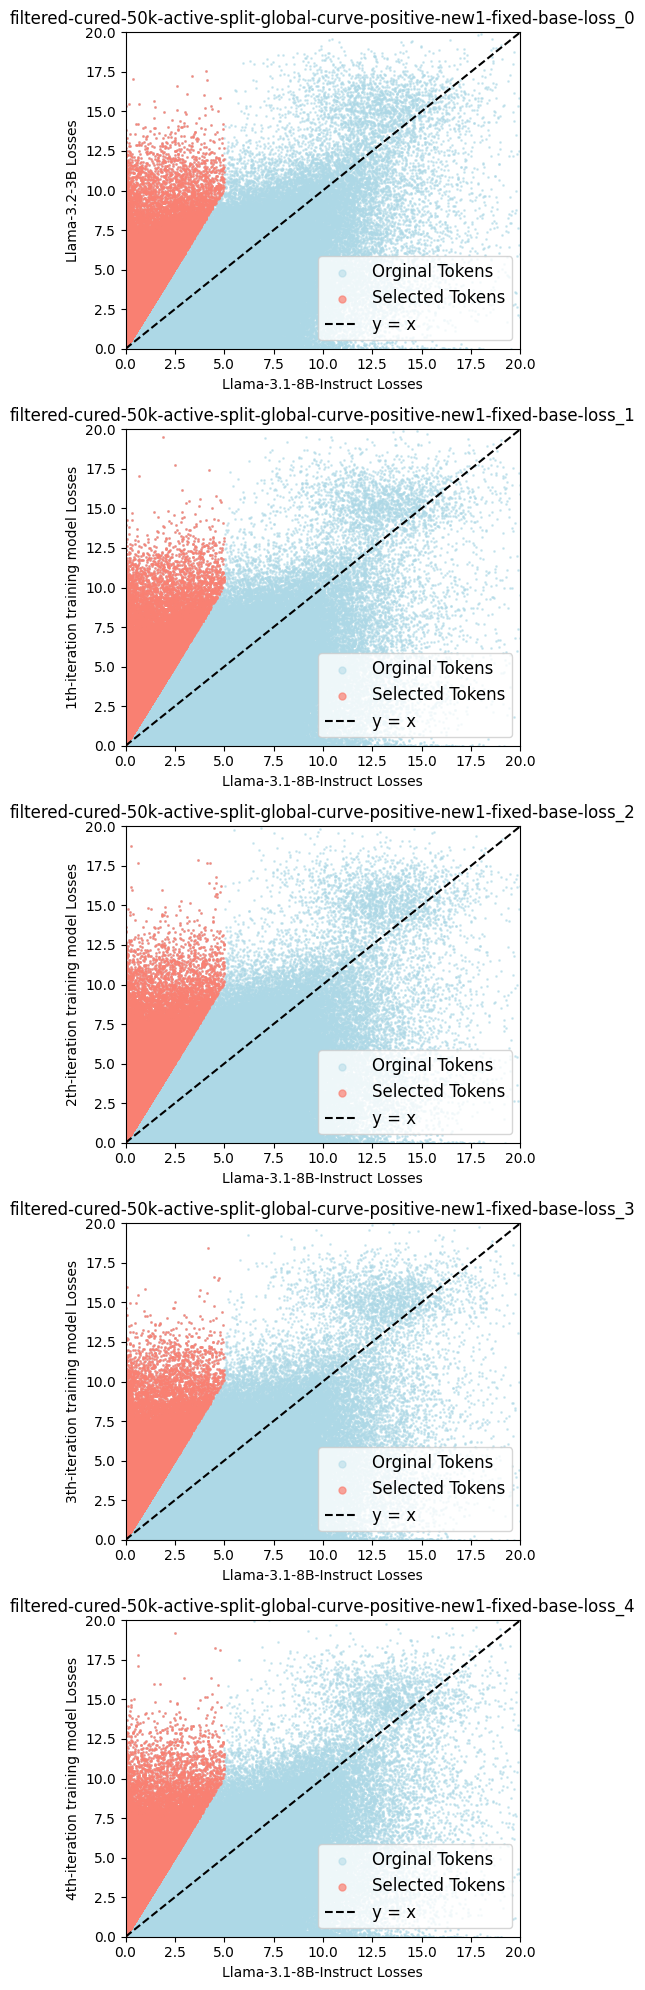

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):
    flattened = [(value, idx) for idx, value in enumerate(data)]
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k]  ##loss
    top_k_indices = [item[1] for item in top_k]
    return top_k_indices


def get_half_positive_indices(data):
    selected_flattened = [(value, idx) for idx, value in enumerate(data) if value > 0]
    top_half_positive = sorted(selected_flattened, key=lambda x: x[0], reverse=True)[:int(len(selected_flattened)/2)] ##loss

    top_half_positive_indices = [item[1] for item in top_half_positive]
    return top_half_positive_indices

def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 2
    beta = 0.07
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta and sample_losses_cur <5: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices

# Data and training parameters
###################################################
loss_path="results/loss/"
ref_model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
base_model_name_or_path = "meta-llama/Llama-3.2-3B"
# dataset_name = "alpaca_52k-active-split"
# dataset_name="filtered-cured-50k-active-split-global-curve-positive"


# dataset_name="filtered-cured-50k-active-split-global-curve-positive-new"
# dataset_name="random_subset_50k-active-split-global-curve-positive-new"

# dataset_name="filtered-cured-50k-iter-split-global-curve-positive-new"
# dataset_name="random_subset_50k-iter-split-global-curve-positive-new"

# dataset_name="filtered-cured-50k-iter-split-global-curve-positive-new1" 
# dataset_name="filtered-cured-50k-iter-split-token-ranking-sample"
# dataset_name = "filtered-cured-50k-active-split-global-curve-positive-new1"
# dataset_name="filtered-cured-50k-active-split-global-half-positive-new1"
# dataset_name="filtered-cured-50k-active-split-global-half-positive-new1-shuffle"
# dataset_name="filtered-cured-50k-active-split-global-curve-positive-reverse"


# dataset_name="filtered-cured-50k-active-split-global-curve-positive-reverse-loss-sum"

dataset_name="filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss"

subset_size = 5 # 增加子集数量以绘制多个子图
data_prop = 0.6

ref_model_name = os.path.basename(ref_model_name_or_path)

# 创建一个大的图形框架
# fig, axes = plt.subplots(1, subset_size, figsize=(5 * subset_size, 4))

fig, axes = plt.subplots(subset_size, 1, figsize=( 5, 4 * subset_size))


for idx in range(subset_size):
    dataset_name_tag = f"{dataset_name}_{idx}"

    if idx == 0:
        cur_train_model_name = os.path.basename(base_model_name_or_path)
        cur_train_model_tag = os.path.basename(base_model_name_or_path)
    else:
        cur_train_model_name = f"lora_merged_{dataset_name}_{idx-1}"
        cur_train_model_tag = f"{idx}th-iteration training model"
        
    losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
    losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")
    
    # if "Llama-3.2-3B" in cur_train_model_name: ## load from existing model
    #     if "filtered-cured-50k" in dataset_name_tag:
    #         base_loss_path = loss_path + f"token_losses_filtered-cured-50k_all_{cur_train_model_name}.pt" 
    #     elif "random_subset_50k" in dataset_name_tag:
    #         base_loss_path = loss_path + f"token_losses_random_subset_50k_all_{cur_train_model_name}.pt"    
    #     else:
    #         print("unknow dataset, please check whether generate the loss for base model.")
    #         raise NotImplementedError
        
    #     print(f"load the first round base model from existing file: {base_loss_path}")
    #     all_losses = torch.load(base_loss_path)
    #     subset_examples = int(len(all_losses) / subset_size)
    #     losses_cur_train = all_losses[:subset_examples]
        
    # else:
    #     losses_cur_train = torch.load(loss_path + f"token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
        

    #     ############### reference model loss #############
    # if "filtered-cured-50k" in dataset_name_tag and ref_model_name == "Llama-3.1-8B-Instruct":
    #     reference_loss_path = loss_path + f"token_losses_filtered-cured-50k_all_{ref_model_name}.pt"
    # elif "random_subset_50k" in dataset_name_tag and ref_model_name == "Llama-3.1-8B-Instruct":
    #     reference_loss_path = loss_path + f"token_losses_random_subset_50k_all_{ref_model_name}.pt"
    # else:
    #     reference_loss_path = None
        
    # ### reuse the existing reference loss
    # if  reference_loss_path and os.path.exists(reference_loss_path):
    #     print(f"load the reference losses from existing file: {reference_loss_path}")
    #     all_losses = torch.load(reference_loss_path)
    #     subset_examples = int(len(all_losses) / subset_size)
    #     losses_ref = all_losses[idx*subset_examples:(idx+1)*subset_examples]
    # else:
    #     losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")
    ############### reference model loss #############
    
    input_cur_train = [value for sublist in losses_cur_train for value in sublist]
    input_ref = [value for sublist in losses_ref for value in sublist]

    # 计算两个模型的损失差异
    losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_cur_train, input_ref)]

    all_token_count = sum(len(losses) for losses in losses_ref)
    print(f"#### all token counting: {all_token_count}\n")

    print(f"Dataset: {dataset_name_tag} -- Token proportion with positive loss diff : {round(sum(1 for loss in losses_diff if loss > 0) / len(losses_diff) * 100, 2)}%")

    # select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))
    # select_global_tokens_indices = get_half_positive_indices(losses_diff)
    select_global_tokens_indices = get_curve_positive_indices(input_cur_train, input_ref)
    print(f"Dataset: {dataset_name_tag} -- selected Token proportion with positive loss diff: {round(len(select_global_tokens_indices) / len(losses_diff) * 100, 2)}%")

    # 选择合适的子图
    ax = axes[idx]  # 选择对应的子图轴

    # 绘制散点图
    ax.scatter(input_ref, input_cur_train, c='lightblue', s=1, alpha=0.5, label='Orginal Tokens')

    selected_train = [input_cur_train[i] for i in select_global_tokens_indices]
    selected_ref = [input_ref[i] for i in select_global_tokens_indices]
    ax.scatter(selected_ref, selected_train, c='salmon', s=1, label="Selected Tokens", alpha=0.7)

    # 添加标题和标签
    ax.set_title(f"{dataset_name_tag}")
    ax.set_xlabel(f"{ref_model_name} Losses")
    ax.set_ylabel(f"{cur_train_model_tag} Losses")

    # 绘制对角线 y = x
    min_val = min(min(input_cur_train), min(input_ref))
    max_val = max(max(input_cur_train), max(input_ref))
    ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')

    # x_vals = np.linspace(min_val, max_val, 500)
    # y_vals = 1.2 * x_vals + 3
    # ax.plot(x_vals, y_vals, color='black', linestyle='-', label='y = 1.2x +3')
    # ax.set_xscale('log')  # 如果你想要对 x 轴应用对数尺度
    # ax.set_yscale('log')  # 如果你想要对 y 轴应用对数尺度
    
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    # 显示图例
    ax.legend(fontsize=12, markerscale=5, loc='lower right')

# 调整图形布局
plt.tight_layout()

# 显示所有子图
plt.show()


In [16]:
def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 1.2
    beta = 0.05
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta and sample_losses_cur < 500: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices

select_global_tokens_indices = get_curve_positive_indices(input_cur_train, input_ref)

len(select_global_tokens_indices) /len(losses_diff)

0.1708264783496251

In [10]:
half_indices = get_half_positive_indices(losses_diff)

In [11]:
losses_diff[half_indices[-1]]

0.05073961054586107

## Compare the token losses with the active model loss



/tmp/ipykernel_653536/3624752223.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train

#### all token counting: 5194741

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_1 -- Token proportion with positive loss diff : 41.39%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_1 -- selected Token proportion with positive loss diff: 60.0%
#### all token counting: 5092345

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_2 -- Token proportion with positive loss diff : 33.9%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_2 -- selected Token proportion with positive loss diff: 60.0%
#### all token counting: 4820634

Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_3 -- Token proportion with positive loss diff : 44.66%
Dataset: filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss_3 -- selected Token proportion with positive loss diff: 60.0%
#### all token counting: 4366465

Dataset: f

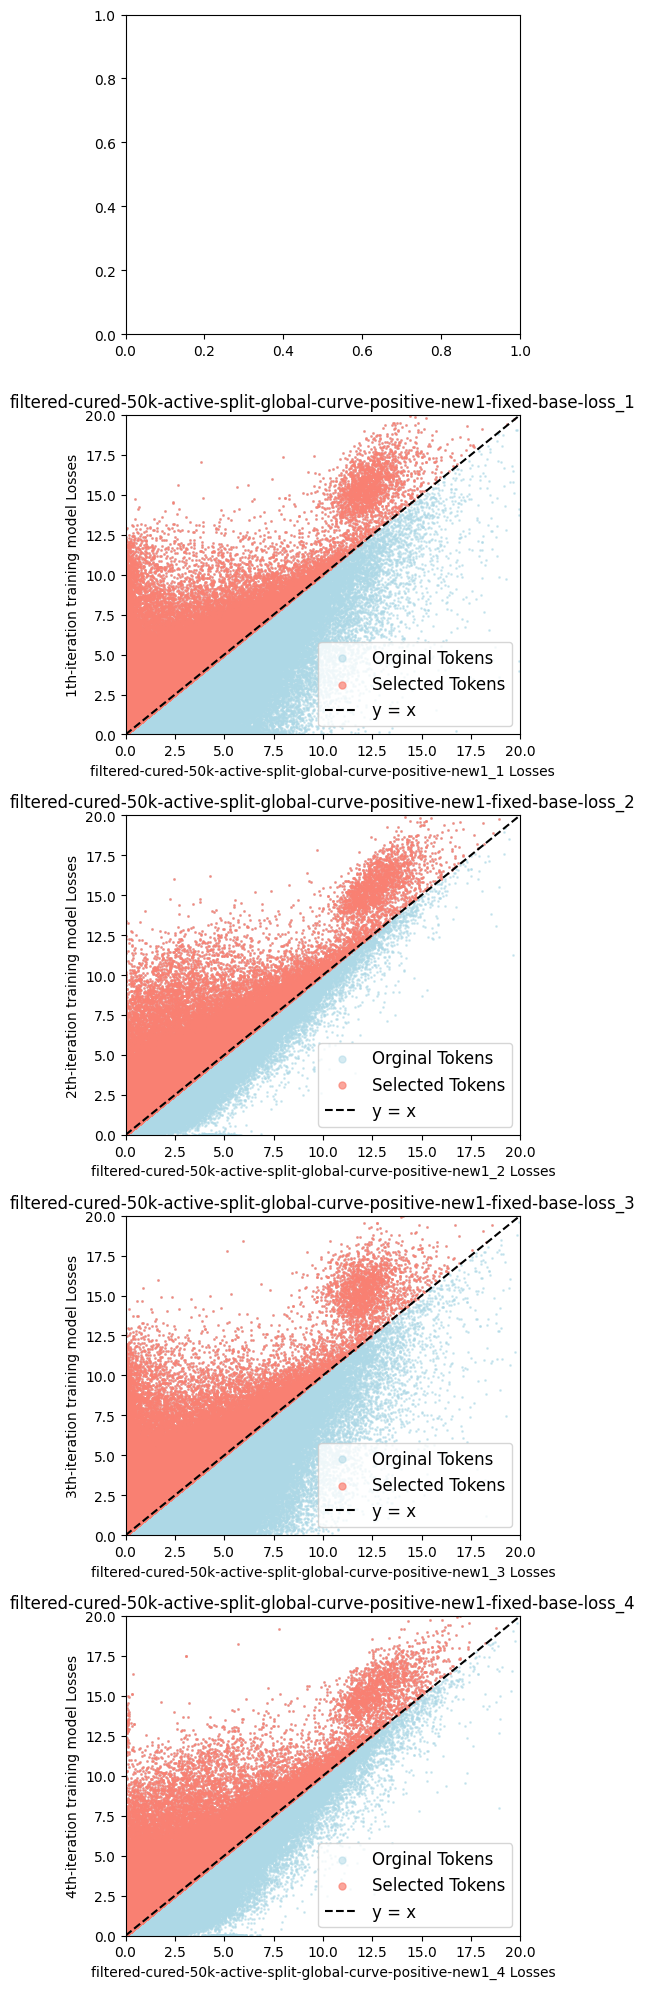

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):
    flattened = [(value, idx) for idx, value in enumerate(data)]
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k]  ##loss
    top_k_indices = [item[1] for item in top_k]
    return top_k_indices


def get_half_positive_indices(data):
    selected_flattened = [(value, idx) for idx, value in enumerate(data) if value > 0]
    top_half_positive = sorted(selected_flattened, key=lambda x: x[0], reverse=True)[:int(len(selected_flattened)/2)] ##loss

    top_half_positive_indices = [item[1] for item in top_half_positive]
    return top_half_positive_indices

def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 2
    beta = 0.07
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta and sample_losses_cur <5: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices

# Data and training parameters
###################################################
loss_path="results/loss/"
ref_model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
base_model_name_or_path = "meta-llama/Llama-3.2-3B"
# dataset_name = "alpaca_52k-active-split"
# dataset_name="filtered-cured-50k-active-split-global-curve-positive"


# dataset_name="filtered-cured-50k-active-split-global-curve-positive-new"
# dataset_name="random_subset_50k-active-split-global-curve-positive-new"

# dataset_name="filtered-cured-50k-iter-split-global-curve-positive-new"
# dataset_name="random_subset_50k-iter-split-global-curve-positive-new"

# dataset_name="filtered-cured-50k-iter-split-global-curve-positive-new1" 
# dataset_name="filtered-cured-50k-iter-split-token-ranking-sample"
# dataset_name = "filtered-cured-50k-active-split-global-curve-positive-new1"
# dataset_name="filtered-cured-50k-active-split-global-half-positive-new1"
# dataset_name="filtered-cured-50k-active-split-global-half-positive-new1-shuffle"
# dataset_name="filtered-cured-50k-active-split-global-curve-positive-reverse"


# dataset_name="filtered-cured-50k-active-split-global-curve-positive-reverse-loss-sum"
ref_dataset_name = "filtered-cured-50k-active-split-global-curve-positive-new1"

# dataset_name="filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss"


subset_size = 5 # 增加子集数量以绘制多个子图
data_prop = 0.6

ref_model_name = os.path.basename(ref_model_name_or_path)

# 创建一个大的图形框架
# fig, axes = plt.subplots(1, subset_size, figsize=(5 * subset_size, 4))

fig, axes = plt.subplots(subset_size, 1, figsize=( 5, 4 * subset_size))


for idx in range(subset_size):
    dataset_name_tag = f"{dataset_name}_{idx}"
    ref_dataset_name_tag = f"{ref_dataset_name}_{idx}"
    ref_model_name = ref_dataset_name_tag
    if idx == 0:
        cur_train_model_name = os.path.basename(base_model_name_or_path)
        cur_train_model_tag = os.path.basename(base_model_name_or_path)
        cur_ref_train_model_name =  os.path.basename(base_model_name_or_path)
    else:
        cur_train_model_name = f"lora_merged_{dataset_name}_{idx-1}"
        cur_ref_train_model_name = f"lora_merged_{ref_dataset_name}_{idx-1}"
        cur_train_model_tag = f"{idx}th-iteration training model"
        
    losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
    losses_ref = torch.load(f"results/loss/token_losses_{ref_dataset_name_tag}_{cur_ref_train_model_name}.pt")
    # losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")
    
    # if "Llama-3.2-3B" in cur_train_model_name: ## load from existing model
    #     if "filtered-cured-50k" in dataset_name_tag:
    #         base_loss_path = loss_path + f"token_losses_filtered-cured-50k_all_{cur_train_model_name}.pt" 
    #     elif "random_subset_50k" in dataset_name_tag:
    #         base_loss_path = loss_path + f"token_losses_random_subset_50k_all_{cur_train_model_name}.pt"    
    #     else:
    #         print("unknow dataset, please check whether generate the loss for base model.")
    #         raise NotImplementedError
        
    #     print(f"load the first round base model from existing file: {base_loss_path}")
    #     all_losses = torch.load(base_loss_path)
    #     subset_examples = int(len(all_losses) / subset_size)
    #     losses_cur_train = all_losses[:subset_examples]
        
    # else:
    #     losses_cur_train = torch.load(loss_path + f"token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
        

    #     ############### reference model loss #############
    # if "filtered-cured-50k" in dataset_name_tag and ref_model_name == "Llama-3.1-8B-Instruct":
    #     reference_loss_path = loss_path + f"token_losses_filtered-cured-50k_all_{ref_model_name}.pt"
    # elif "random_subset_50k" in dataset_name_tag and ref_model_name == "Llama-3.1-8B-Instruct":
    #     reference_loss_path = loss_path + f"token_losses_random_subset_50k_all_{ref_model_name}.pt"
    # else:
    #     reference_loss_path = None
        
    # ### reuse the existing reference loss
    # if  reference_loss_path and os.path.exists(reference_loss_path):
    #     print(f"load the reference losses from existing file: {reference_loss_path}")
    #     all_losses = torch.load(reference_loss_path)
    #     subset_examples = int(len(all_losses) / subset_size)
    #     losses_ref = all_losses[idx*subset_examples:(idx+1)*subset_examples]
    # else:
    #     losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")
    ############### reference model loss #############
    
    input_cur_train = [value for sublist in losses_cur_train for value in sublist]
    input_ref = [value for sublist in losses_ref for value in sublist]

    # 计算两个模型的损失差异
    losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_cur_train, input_ref)]

    all_token_count = sum(len(losses) for losses in losses_ref)
    print(f"#### all token counting: {all_token_count}\n")

    print(f"Dataset: {dataset_name_tag} -- Token proportion with positive loss diff : {round(sum(1 for loss in losses_diff if loss > 0) / len(losses_diff) * 100, 2)}%")

    select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))
    # select_global_tokens_indices = get_half_positive_indices(losses_diff)
    # select_global_tokens_indices = get_curve_positive_indices(input_cur_train, input_ref)
    print(f"Dataset: {dataset_name_tag} -- selected Token proportion with positive loss diff: {round(len(select_global_tokens_indices) / len(losses_diff) * 100, 2)}%")

    # 选择合适的子图
    ax = axes[idx]  # 选择对应的子图轴

    # 绘制散点图
    ax.scatter(input_ref, input_cur_train, c='lightblue', s=1, alpha=0.5, label='Orginal Tokens')

    selected_train = [input_cur_train[i] for i in select_global_tokens_indices]
    selected_ref = [input_ref[i] for i in select_global_tokens_indices]
    ax.scatter(selected_ref, selected_train, c='salmon', s=1, label="Selected Tokens", alpha=0.7)

    # 添加标题和标签
    ax.set_title(f"{dataset_name_tag}")
    ax.set_xlabel(f"{ref_model_name} Losses")
    ax.set_ylabel(f"{cur_train_model_tag} Losses")

    # 绘制对角线 y = x
    min_val = min(min(input_cur_train), min(input_ref))
    max_val = max(max(input_cur_train), max(input_ref))
    ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')

    # x_vals = np.linspace(min_val, max_val, 500)
    # y_vals = 1.2 * x_vals + 3
    # ax.plot(x_vals, y_vals, color='black', linestyle='-', label='y = 1.2x +3')
    # ax.set_xscale('log')  # 如果你想要对 x 轴应用对数尺度
    # ax.set_yscale('log')  # 如果你想要对 y 轴应用对数尺度
    
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    # 显示图例
    ax.legend(fontsize=12, markerscale=5, loc='lower right')

# 调整图形布局
plt.tight_layout()

# 显示所有子图
plt.show()


## Compare base model loss vs. active split model loss

/tmp/ipykernel_672345/1770014173.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train

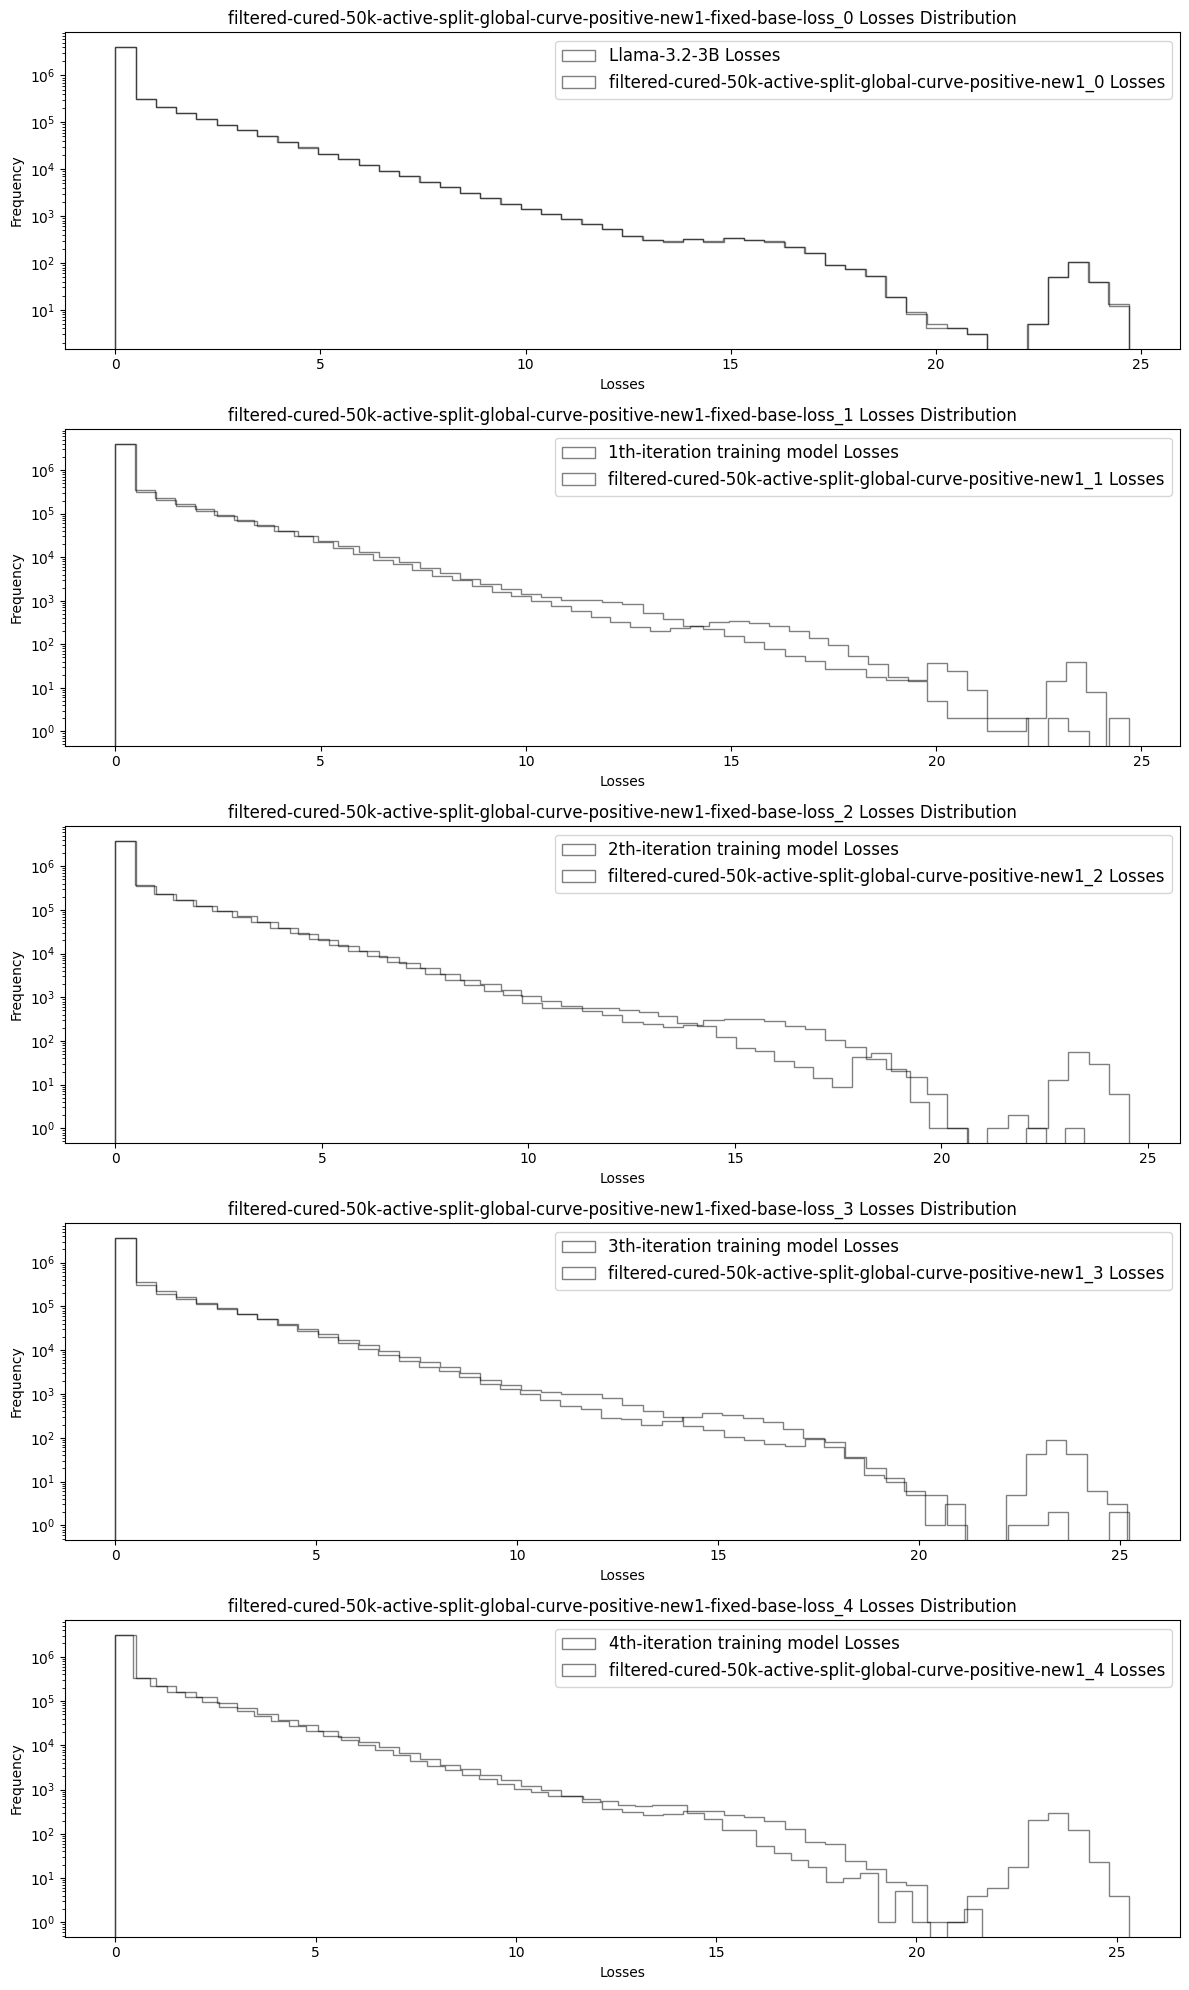

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):
    flattened = [(value, idx) for idx, value in enumerate(data)]
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k]  ##loss
    top_k_indices = [item[1] for item in top_k]
    return top_k_indices


def get_half_positive_indices(data):
    selected_flattened = [(value, idx) for idx, value in enumerate(data) if value > 0]
    top_half_positive = sorted(selected_flattened, key=lambda x: x[0], reverse=True)[:int(len(selected_flattened)/2)] ##loss

    top_half_positive_indices = [item[1] for item in top_half_positive]
    return top_half_positive_indices

def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 2
    beta = 0.07
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta and sample_losses_cur <5: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices

# Data and training parameters
###################################################
loss_path="results/loss/"
ref_model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
base_model_name_or_path = "meta-llama/Llama-3.2-3B"

ref_dataset_name = "filtered-cured-50k-active-split-global-curve-positive-new1"

dataset_name="filtered-cured-50k-active-split-global-curve-positive-new1-fixed-base-loss"

subset_size = 5  # Number of subsets to generate multiple subplots
data_prop = 0.6

ref_model_name = os.path.basename(ref_model_name_or_path)

# Create a figure with subplots
fig, axes = plt.subplots(subset_size, 1, figsize=(12, 4 * subset_size))

for idx in range(subset_size):
    dataset_name_tag = f"{dataset_name}_{idx}"
    ref_dataset_name_tag = f"{ref_dataset_name}_{idx}"
    ref_model_name = ref_dataset_name_tag
    if idx == 0:
        cur_train_model_name = os.path.basename(base_model_name_or_path)
        cur_train_model_tag = os.path.basename(base_model_name_or_path)
        cur_ref_train_model_name = os.path.basename(base_model_name_or_path)
    else:
        cur_train_model_name = f"lora_merged_{dataset_name}_{idx-1}"
        cur_ref_train_model_name = f"lora_merged_{ref_dataset_name}_{idx-1}"
        cur_train_model_tag = f"{idx}th-iteration training model"
        
    losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
    losses_ref = torch.load(f"results/loss/token_losses_{ref_dataset_name_tag}_{cur_ref_train_model_name}.pt")
    
    input_cur_train = [value for sublist in losses_cur_train for value in sublist]
    input_ref = [value for sublist in losses_ref for value in sublist]


    ax = axes[idx]
    # ax.hist(input_ref, bins=50, color='lightblue', alpha=0.7, edgecolor='black', label=f"{ref_model_name} Losses")
    # ax.hist(input_cur_train, bins=50, color='salmon', alpha=0.7, edgecolor='black', label=f"{cur_train_model_tag} Losses")

    # ax.hist(input_cur_train, bins=50, color='salmon', alpha=0.5, edgecolor='black', label=f"{cur_train_model_tag} Losses", histtype='step')
    # ax.hist(input_ref, bins=50, color='lightblue', alpha=0.5, edgecolor='black', label=f"{ref_model_name} Losses", histtype='step')
    
    # ax.hist([input_cur_train, input_ref], bins=25, stack=True, label=[f"{cur_train_model_tag} Losses", f"{ref_model_name} Losses"])
    
    # Set the title and labels
    ax.set_title(f"{dataset_name_tag} Losses Distribution")
    ax.set_xlabel("Losses")
    ax.set_ylabel("Frequency")
    ax.set_yscale('log')  # 如果你想要对 y 轴应用对数尺度

    # Add legend
    ax.legend(fontsize=12, loc='upper right')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


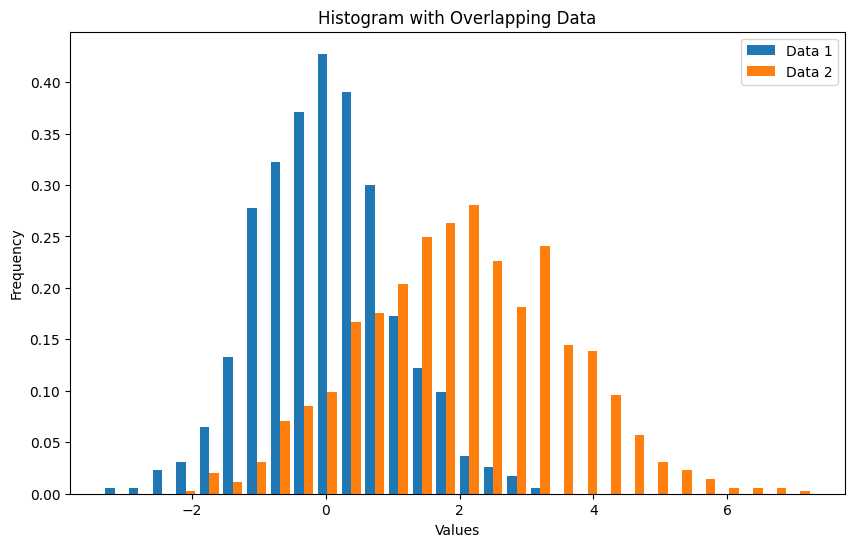

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
data1 = np.random.normal(0, 1, 1000)  # 平均值为0，标准差为1，生成1000个数据点
data2 = np.random.normal(2, 1.5, 1000)  # 平均值为2，标准差为1.5，生成1000个数据点

# 创建图表
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制两个直方图
# ax.hist(data1, bins=30, alpha=0.5, 
#         label='Data 1', color='blue')
# ax.hist(data2, bins=30, alpha=0.5, 
#         label='Data 2', color='red')
# plt.hist([data1, data2], stacked=True, 
#          label=['Data 1', 'Data 2'])

plt.hist([data1, data2], label=['Data 1', 'Data 2'], 
         density=True, bins=30)
plt.legend()
plt.legend()
# 设置轴标签和标题
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Histogram with Overlapping Data')

# 显示图例
ax.legend()

# 显示图表
plt.show()


In [1]:
import torch

combine_labels = torch.load("results/label/token_labels_filtered-cured-50k-iter-split-global_data_prop_0.3_combine_active-split-global-half-positive-fixed-base-loss-using-warmup-label_mistral_1.pt")

warmup_labels = torch.load("results/label/token_labels_filtered-cured-50k-active-split-global-half-positive-fixed-base-loss-using-warmup-mistral_1.pt")
iter_labels = torch.load("results/label/token_labels_filtered-cured-50k-iter-split-global_data_prop_0.3_mistral_1.pt")


/tmp/ipykernel_569434/2551259253.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load("results/label/token_labels_filtered-cured-50k-iter-split-global_dat

In [5]:
from datasets import load_dataset

limo_dataset = load_dataset("GAIR/LIMO")['train']

{"dataset":"flan_v2","id":"flan_v2_22283","messages":[{"role":"user","content":"Solve 211*b = 201*b - 50 for b.\nSolve this problem.\n"},{"role":"assistant","content":"-5"}]}


In [4]:
dataset_all = []
for idx, sample in enumerate(limo_dataset):
    sample_dict = {"dataset": "limo", "id": idx,}
    messages = [{"role": "user", "content": sample['question']},
                {"role": "assistant", "content": sample['solution']}]
    
    

{'question': 'Find the last three digits of the product of the positive roots of $\\sqrt{1995}x^{\\log_{1995}x}=x^2.$',
 'solution': 'Okay, so I need to find the last three digits of the product of the positive roots of the equation √(1995) * x^(log_{1995} x) = x². Hmm, let\'s see. First, let me try to understand the equation and figure out how to solve it. \n\nThe equation is given as √(1995) * x^(log_{1995} x) = x². That looks a bit complicated with the logarithm in the exponent. Maybe I can take logarithms on both sides to simplify it? Or perhaps rewrite the equation using properties of exponents and logarithms. \n\nLet me recall that log_b a = (ln a)/(ln b), so log_{1995} x is equal to (ln x)/(ln 1995). Also, x raised to log_{1995} x can be rewritten using exponentials. Wait, maybe I can express x^(log_{1995} x) as e^{(ln x) * (log_{1995} x)}. But that might not be helpful. Let me think differently.\n\nAlternatively, since the equation has x in the exponent and also x squared, mayb